/tmp/ipython-input-8-1875347407.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TCS.NS', start='2014-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0183 - val_loss: 0.0019
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0014 - val_loss: 7.6152e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0011 - val_loss: 7.7726e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0014 - val_loss: 7.8765e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 9.4620e-04 - val_loss: 8.1639e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 8.2221e-04 - val_loss: 6.8994e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 7.3825e-04 - val_loss: 8.1061e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 8.7288e-04 - val_loss: 7.7537e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 8.3410e-04 - val_loss: 6.4808e-04
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 9.2462e-04 - val_loss: 6.4506e-04
Epoch 12/50
60

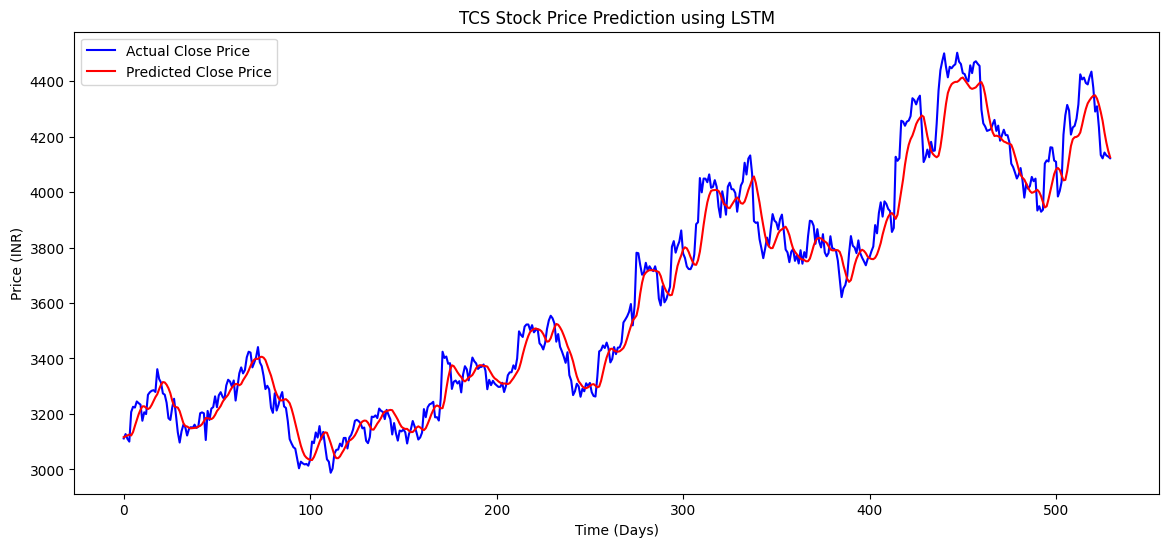

RMSE: 76.0920, MAE: 57.6823
R^2 Score: 0.9676


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

#  Downloading TCS stock data (10 years)
df = yf.download('TCS.NS', start='2014-01-01', end='2024-12-31')

#  Selecting multiple relevant features
data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

#  Scaling features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

#  Creating sequences (X) and targets (y)
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 3])

X, y = np.array(X), np.array(y)

#  Spliting into train and test sets (80-20 split)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#  Building LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1))  # Predicting next day's Close price

model.compile(optimizer='adam', loss='mean_squared_error')

#  Training with EarlyStopping on validation set
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

#  Predicting on test set
y_pred_scaled = model.predict(X_test)

#  Inversing scale predictions and true values for Close price only
#  We need to inverse transform only the Close price column (index 3)
y_pred_extended = np.zeros((len(y_pred_scaled), scaled_data.shape[1]))
y_pred_extended[:, 3] = y_pred_scaled[:, 0]

y_test_extended = np.zeros((len(y_test), scaled_data.shape[1]))
y_test_extended[:, 3] = y_test

y_pred = scaler.inverse_transform(y_pred_extended)[:, 3]
y_true = scaler.inverse_transform(y_test_extended)[:, 3]

#  Plotting actual vs predicted prices
plt.figure(figsize=(14,6))
plt.plot(y_true, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red')
plt.title('TCS Stock Price Prediction using LSTM')
plt.xlabel('Time (Days)')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

# Printing the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')

from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R^2 Score: {r2:.4f}")
